### Basic QC for non-human primate samples (Gideon)

#### Objective: Run basic QC for week 10 BAL samples in non-human primates from Gideon et al 2021

- **Developed by**: Mairi McClean
- **Affiliation**: Institute of Computational Biology, Computational Health Centre, Helmholtz Munich
- **v221209**

## Load modules

In [1]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import igraph as ig
from matplotlib import colors
from matplotlib import rcParams

In [9]:
%matplotlib inline
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.9.1
scanpy      1.9.3
-----
CoreFoundation      NA
Foundation          NA
PIL                 9.5.0
PyObjCTools         NA
anyio               NA
appnope             0.1.3
asttokens           NA
attr                23.1.0
babel               2.12.1
backcall            0.2.0
certifi             2023.05.07
cffi                1.15.1
charset_normalizer  3.1.0
cloudpickle         2.2.1
colorama            0.4.6
comm                0.1.3
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.0
dask                2023.5.1
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
executing           1.2.0
fastjsonschema      NA
h5py                3.8.0
idna                3.4
igraph              0.10.4
importlib_resources NA
ipykernel           6.23.1
jedi                0.18.2
jinja2              3.1.2
joblib              1.2.0
json5               NA
jsonschema          4.17.3
jupyter_events      0.6.3
ju

### Read in datasets

In [3]:
adata = sc.read_10x_mtx('/Users/mairi.mcclean/example_data_lake/INBOX/tb_cc/raw_data_objects/nhp/gideon2021/week10/')
adata

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


AnnData object with n_obs × n_vars = 109584 × 28155
    var: 'gene_ids'

- Fix .var objects

In [4]:
adata.var

,gene_ids
A1BG,NaN
A2ML1,0.0
A3GALT2,1.0
A4GALT,2.0
A4GNT,3.0
...,...
LOC107130452,28149.0
LOC107130791,28150.0
SCP2D1,28151.0
TAS2R8,28152.0


In [5]:
adata.var.rename(columns={'gene_ids': 'gene_name'}, inplace=True)
adata.var


,gene_name
A1BG,NaN
A2ML1,0.0
A3GALT2,1.0
A4GALT,2.0
A4GNT,3.0
...,...
LOC107130452,28149.0
LOC107130791,28150.0
SCP2D1,28151.0
TAS2R8,28152.0


In [6]:
adata.var = adata.var.drop('gene_name', axis=1)

- Make names unique 


In [7]:
adata.var_names_make_unique()
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 109584 × 28155

In [8]:
# Make sure that all names are unique in new data object. 

# Turns var names into string - always required?
sample_object.var_names = [str(i) for i in sample_object.var_names]
sample_object.var_names_make_unique()

### Top 20 scatterplot

normalizing counts per cell
    finished (0:00:00)


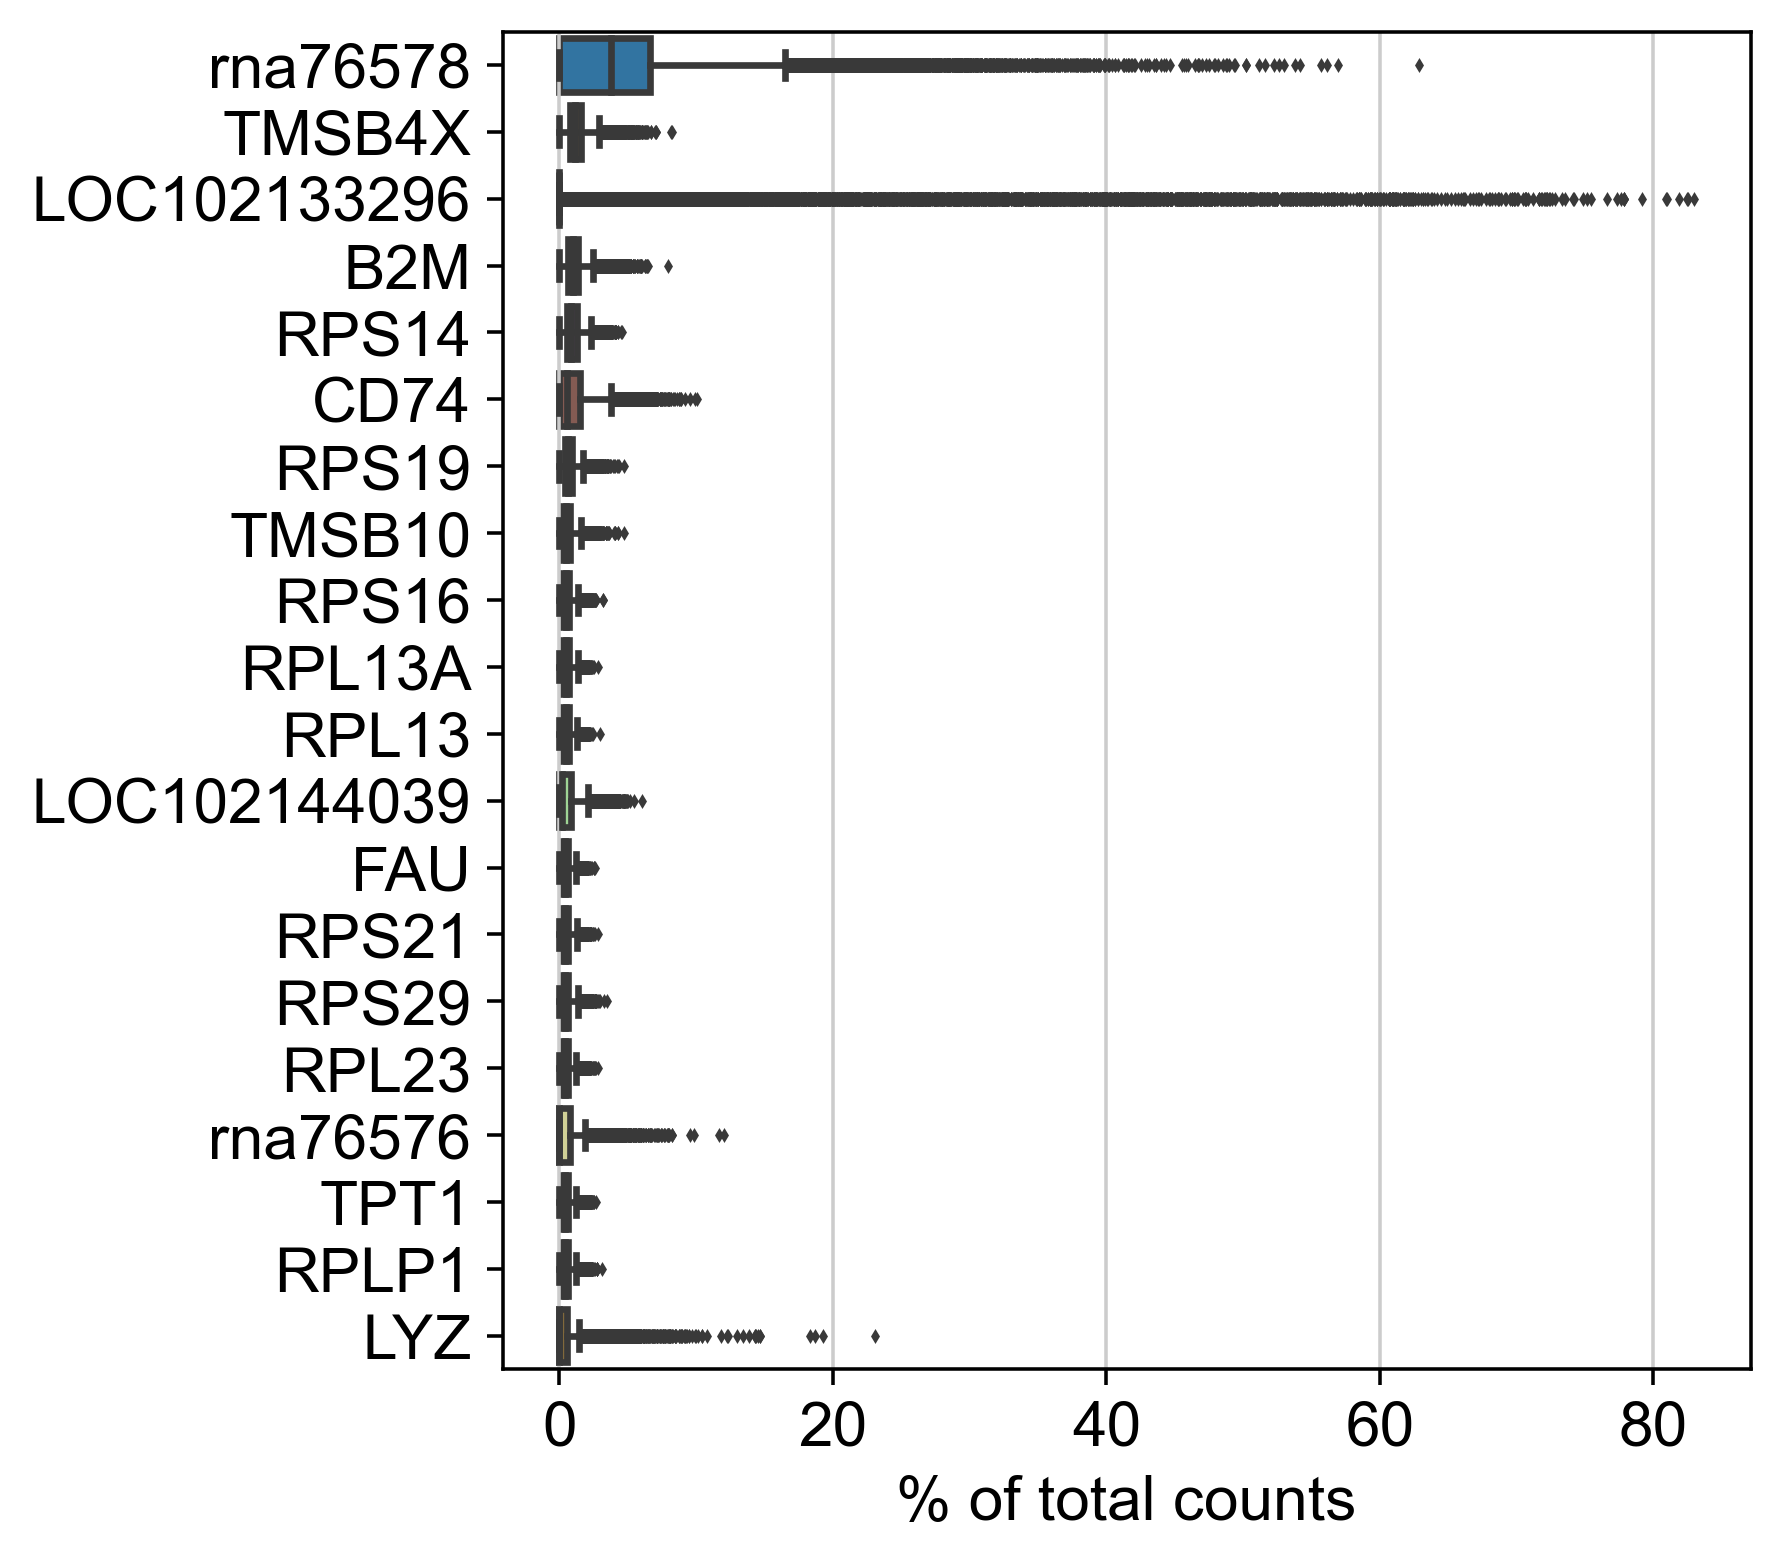

In [10]:
sc.pl.highest_expr_genes(sample_object, n_top=20)

### Inital filtering

- By gene number

In [11]:
sc.pp.filter_cells(sample_object, min_genes = 200)
print(sample_object.n_obs, sample_object.n_vars)

filtered out 283 cells that have less than 200 genes expressed
109301 28155


- By cell number 

In [12]:
sc.pp.filter_genes(sample_object, min_cells = 3)
sample_object.shape

filtered out 2349 genes that are detected in less than 3 cells


(109301, 25806)

### QC metrics

In [14]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('MT')
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("RPS","RPL"))
sample_object.var["hb"] = sample_object.var_names.str.contains(("^HB[^(P)]"))
sample_object.var

,n_cells,mt,ribo,hb
A1BG,4,False,False,False
A2ML1,138,False,False,False
A3GALT2,29,False,False,False
A4GALT,2555,False,False,False
A4GNT,16,False,False,False
...,...,...,...,...
LOC107129873,3,False,False,False
LOC107130145,3,False,False,False
LRRC52,3,False,False,False
SPAG11B,3,False,False,False


In [15]:
sample_object.var['mt'].value_counts()

mt
False    25738
True        68
Name: count, dtype: int64

In [16]:
sample_object.var['ribo'].value_counts()

ribo
False    25715
True        91
Name: count, dtype: int64

In [17]:
sample_object.var['hb'].value_counts()

hb
False    25799
True         7
Name: count, dtype: int64

In [18]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt', 'ribo', 'hb'], percent_top = None, log1p = False, inplace = True)

In [19]:
sample_object.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb
Array1_3817_AAAACCCATATC,1203,1203,2777.0,2.0,0.072020,61.0,2.196615,0.0,0.000000
Array1_3817_AAAAGTAGTTTA,499,499,991.0,1.0,0.100908,5.0,0.504541,0.0,0.000000
Array1_3817_AAACATTGACCC,1206,1206,1876.0,8.0,0.426439,7.0,0.373134,2.0,0.106610
Array1_3817_AAACGCAATCCT,930,930,1699.0,5.0,0.294291,149.0,8.769865,0.0,0.000000
Array1_3817_AAACGTCGTACA,1168,1168,2332.0,2.0,0.085763,260.0,11.149228,1.0,0.042882
...,...,...,...,...,...,...,...,...,...
Array9_4017_TTTTTGAGGCCT,719,719,1524.0,1.0,0.065617,287.0,18.832020,1.0,0.065617
Array9_4017_TTTTTGGAAACC,685,685,1068.0,4.0,0.374532,75.0,7.022472,1.0,0.093633
Array9_4017_TTTTTGTGCCTC,1467,1467,4488.0,9.0,0.200535,930.0,20.721926,0.0,0.000000
Array9_4017_TTTTTTAAAGAT,690,690,1431.0,8.0,0.559050,242.0,16.911251,0.0,0.000000


- QC visualisation

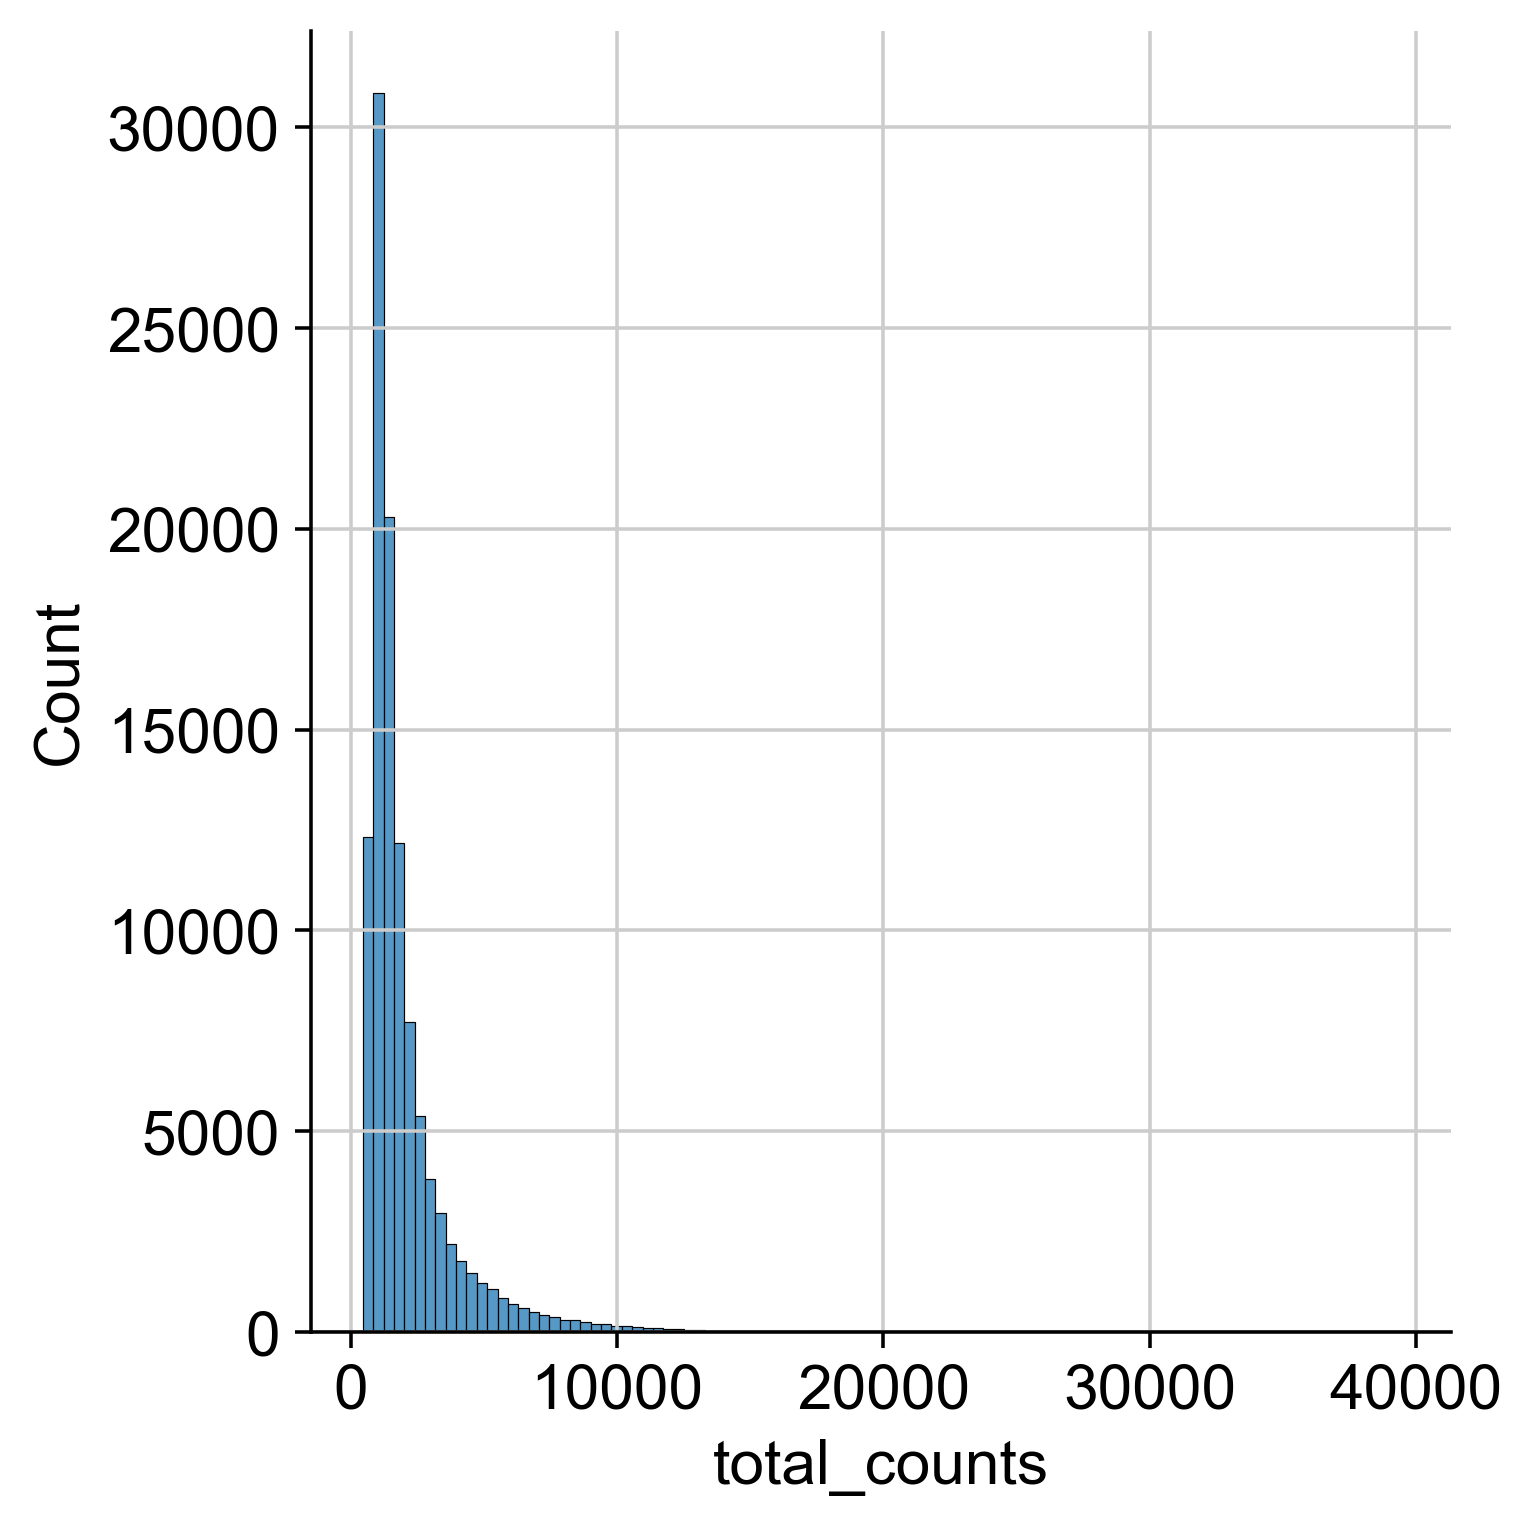

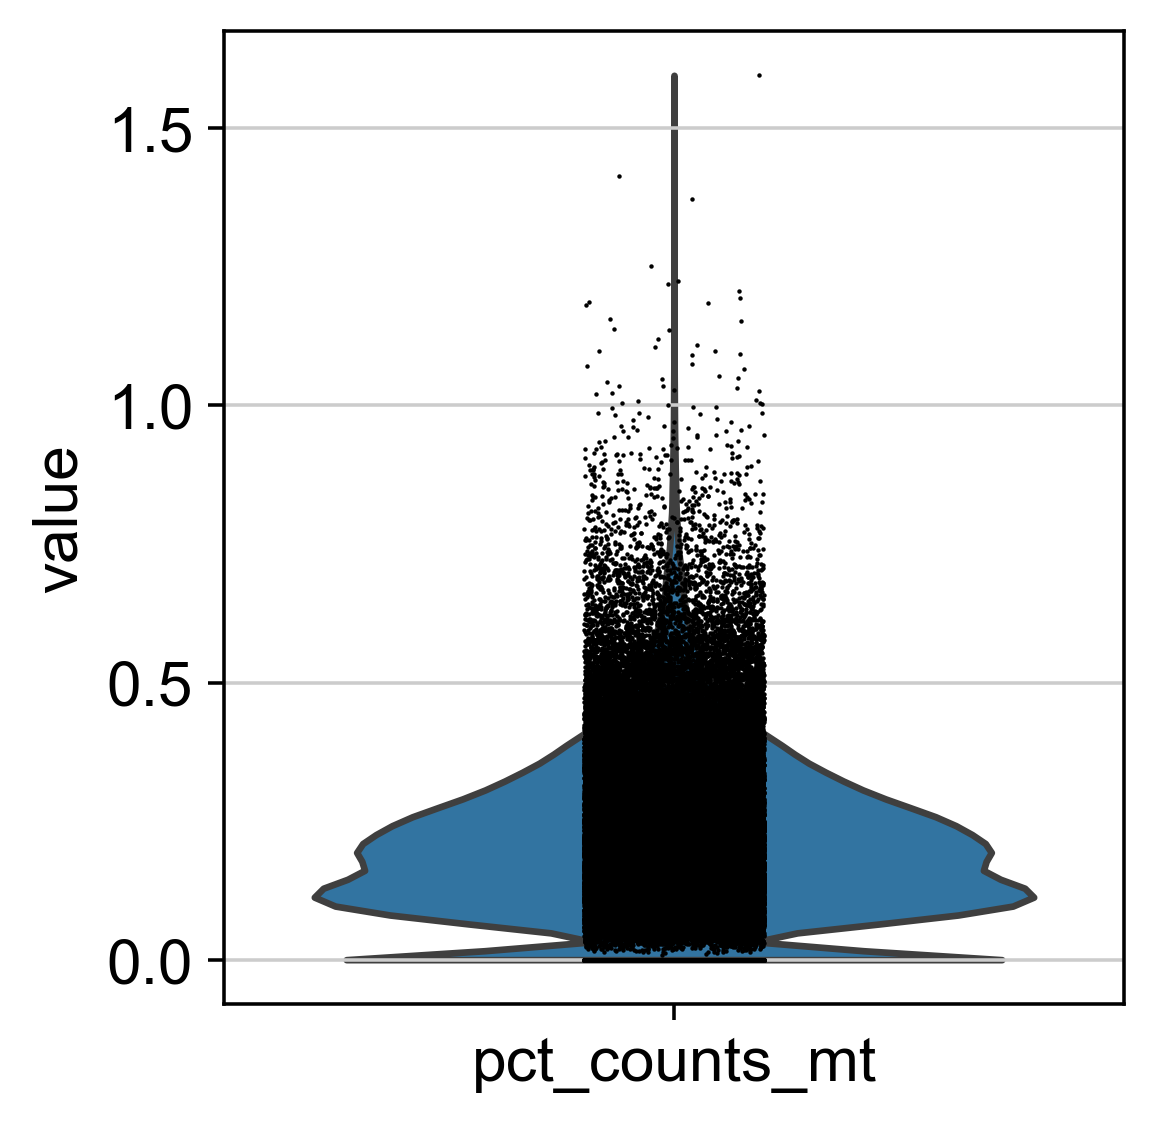

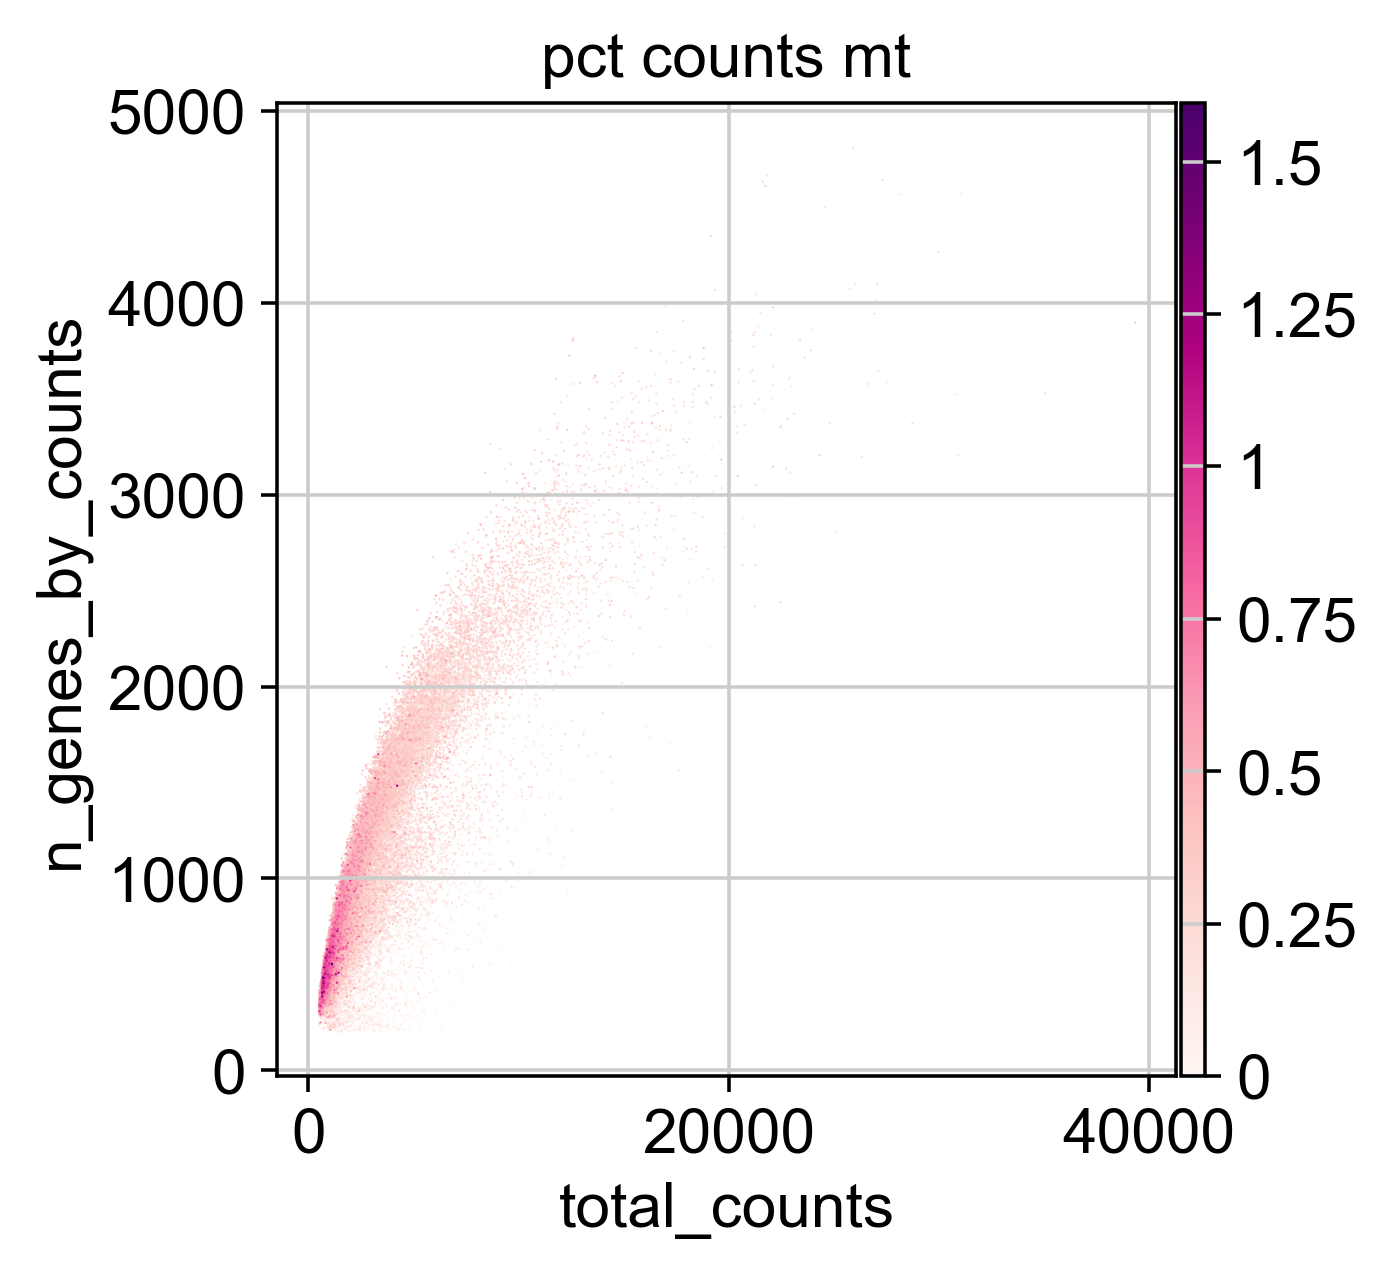

In [20]:
p1 = sns.displot(sample_object.obs["total_counts"], bins=100, kde=False)
# sc.pl.violin(adata, 'total_counts')
p2 = sc.pl.violin(sample_object, "pct_counts_mt")
p3 = sc.pl.scatter(sample_object, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

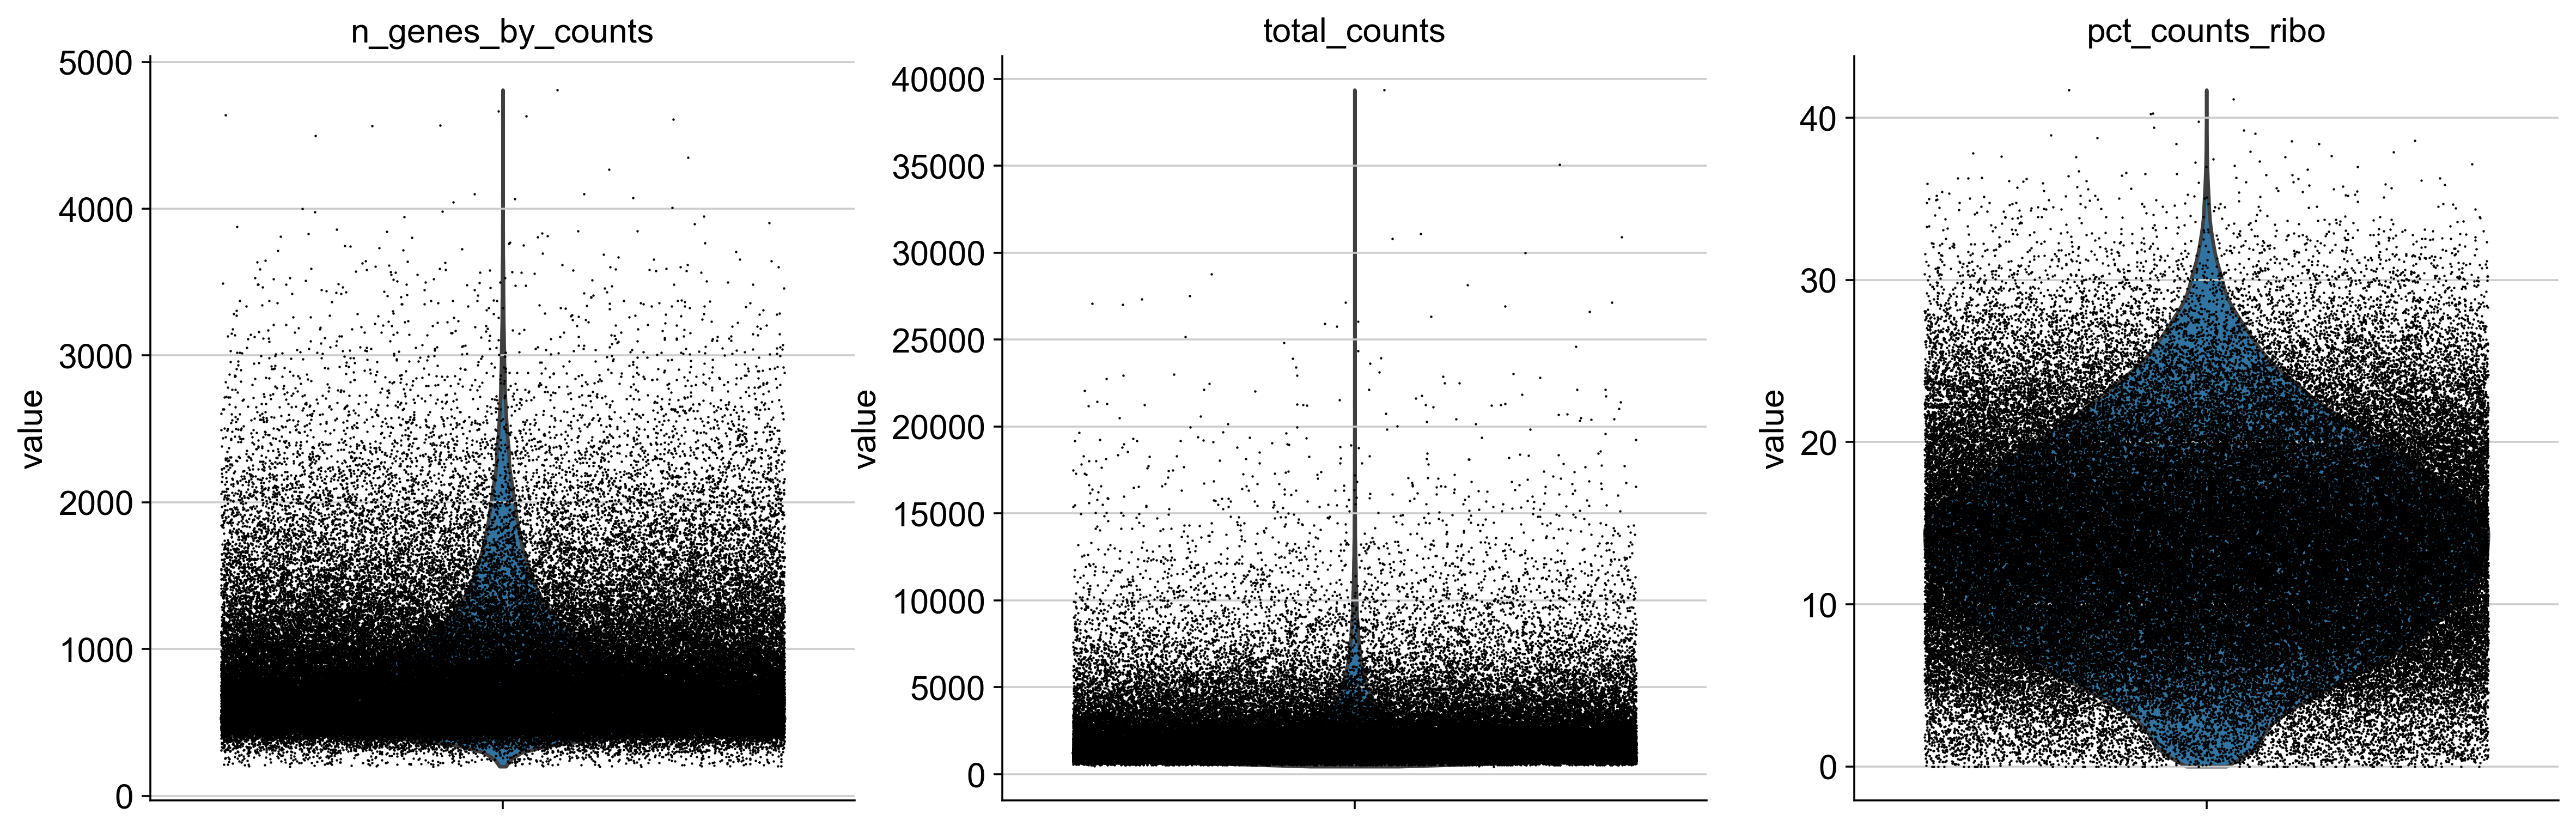

In [21]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

### QC-based filtering

In [22]:
sample_object.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb
Array1_3817_AAAACCCATATC,1203,1203,2777.0,2.0,0.072020,61.0,2.196615,0.0,0.000000
Array1_3817_AAAAGTAGTTTA,499,499,991.0,1.0,0.100908,5.0,0.504541,0.0,0.000000
Array1_3817_AAACATTGACCC,1206,1206,1876.0,8.0,0.426439,7.0,0.373134,2.0,0.106610
Array1_3817_AAACGCAATCCT,930,930,1699.0,5.0,0.294291,149.0,8.769865,0.0,0.000000
Array1_3817_AAACGTCGTACA,1168,1168,2332.0,2.0,0.085763,260.0,11.149228,1.0,0.042882


In [23]:
sample_object.shape

(109301, 25806)

In [24]:
sample_object.obs["mt_ok"] = sample_object.obs['pct_counts_mt'] <= 20
sample_object.obs.head()

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,mt_ok
Array1_3817_AAAACCCATATC,1203,1203,2777.0,2.0,0.072020,61.0,2.196615,0.0,0.000000,True
Array1_3817_AAAAGTAGTTTA,499,499,991.0,1.0,0.100908,5.0,0.504541,0.0,0.000000,True
Array1_3817_AAACATTGACCC,1206,1206,1876.0,8.0,0.426439,7.0,0.373134,2.0,0.106610,True
Array1_3817_AAACGCAATCCT,930,930,1699.0,5.0,0.294291,149.0,8.769865,0.0,0.000000,True
Array1_3817_AAACGTCGTACA,1168,1168,2332.0,2.0,0.085763,260.0,11.149228,1.0,0.042882,True


In [25]:
sample_object.obs.mt_ok.value_counts()

mt_ok
True    109301
Name: count, dtype: int64

In [26]:
print(f"Total number of cells: {sample_object.n_obs}")
sample_object = sample_object[(sample_object.obs.mt_ok)].copy()

print(f"Number of cells after filtering of low quality cells: {sample_object.n_obs}")

Total number of cells: 109301
Number of cells after filtering of low quality cells: 109301


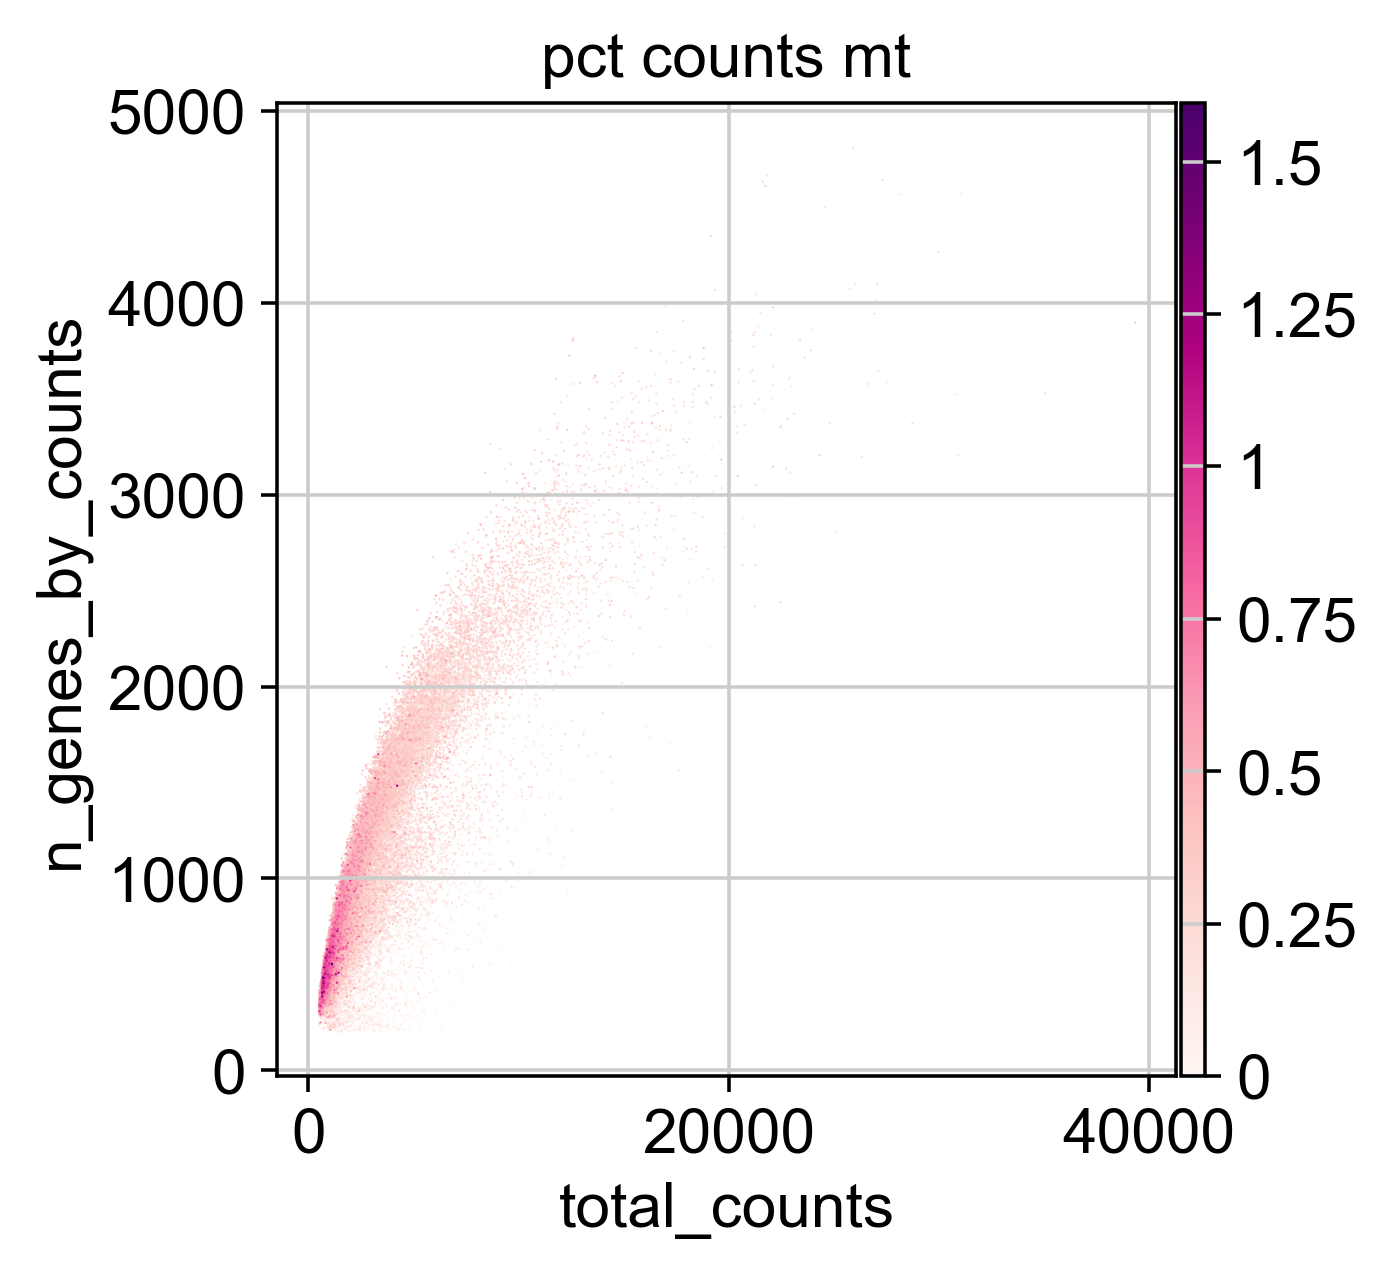

In [27]:
p1 = sc.pl.scatter(sample_object, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Sample sex covariate

In [ ]:
annot = sc.queries.biomart_annotations(
        "mfascicularis",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("ensembl_gene_id")


In [ ]:
annot.head()

- Y chrom

In [ ]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

In [ ]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1 * 100

- X chromo

In [ ]:
chrX_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "X"])
chrX_genes

In [ ]:
chrX_sum = sample_object[:, chrX_genes].X.sum(axis=1)
total_sum = sample_object.X.sum(axis=1)

# Flatten the arrays and calculate percent_chrY
sample_object.obs['percent_chrX'] = (np.asarray(chrX_sum).flatten() / np.asarray(total_sum).flatten()) * 100
sample_object.obs

In [ ]:
# Graph of samples with X chrom
sample_object.obs.percent_chrX.value_counts()

In [ ]:
sample_object.obs.shape

In [ ]:
sc.set_figure_params(figsize=(25, 7),dpi=100)
sc.pl.violin(sample_object, ["percent_chrX"], jitter = 0.4, groupby = 'part', rotation = 45)

### Cell cycle scores

In [ ]:
!if [ ! -f /Users/mairi.mcclean/data/qc_files/mfasc_orthog_cell_cycle_genes.txt ]; then curl -o /Users/mairi.mcclean/data/qc_files/mfasc_orthog_cell_cycle_genes.txt https://raw.githubusercontent.com/Talavera-Lopez-Lab/Mairi-PhD/main/sc_temp_folder/cell_cycle_genes/mfasc_orthog_cell_cycle_genes.txt?token=GHSAT0AAAAAACBVCJYZCXEBCEQZZKWQJC22ZD7AUZA

In [ ]:
cell_cycle_genes = [x.strip() for x in open('/Users/mairi.mcclean/data/qc_files/mfasc_orthog_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
g2m_genes = cell_cycle_genes[:46]
s_genes = cell_cycle_genes[46:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

In [ ]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

In [ ]:
# Set specific figure params

sc.set_figure_params(figsize=(10, 7))
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'part', rotation = 45)

In [ ]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

### Predict doublets

In [ ]:
import scrublet

In [ ]:
scrub = scrublet.Scrublet(sample_object.X)

In [ ]:
sample_object.obs['doublet_scores'], sample_object.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

In [ ]:
sum(sample_object.obs['predicted_doublets'])

In [ ]:
# Re-set figure params
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

# Plot doublet detection results
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'predicted_doublets'],
             jitter = 0.2, groupby = 'part', rotation = 45, multi_panel=False)

### Prepare counts for individual slots

In [ ]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

### Export object

In [ ]:
sample_object.write('/Volumes/Lacie/data_lake/Mairi_example/processed_files/abridged_qc/nhp/Gideon2021_scrna_granhomog_mm_221209_qcd.h5ad')